_First, some initial setup. Remember: the mongo server has to be running._

_Start one by going to your terminal and typing:_

    mongod

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import pymongo

with open("heavy_metal_parsed.pkl", "rb") as datafile:
    reviews = pickle.load(datafile)

client = pymongo.MongoClient()
db = client.challenge_db
hmm = client.challenge_db.hmm_collection

hmm.drop() # Clear out any data we had in the collection.

for review in reviews:
    hmm.save(review)

# Alternativlely try: 
# hmm.insert_many(reviews);

In [2]:
## Some basic exploration
print "Count of number of documents:", hmm.count()
print "Keys in one example document:", hmm.find_one().keys()
#hmm.find_one() # Uncomment this line to see what a full document looks like.

Count of number of documents: 856
Keys in one example document: [u'raw', u'head', u'metal_cred', u'title', u'direct', u'solid_metal_nuggets', u'cast', u'the_meat', u'year', u'_id', u'sections']


### Challenge 1

Make a histogram of the years in the data. How many Heavy Metal films came out over the years?

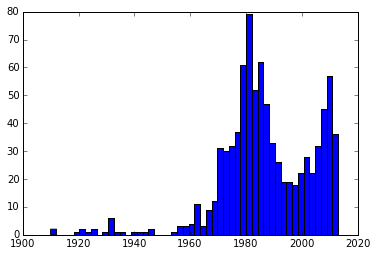

In [5]:
## Scan over all the documents in the collection and build up a list of years the films were
## released.

years = []
for film in hmm.find({}, {"year": 1, "_id": 0}):
    years.append(film["year"])

## Alternatively using a list comprehension.
#years = [film["year"] for film in hmm.find({}, {"year": 1, "_id": 0})]

plt.hist(years, bins=50);

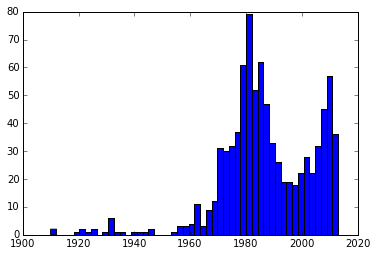

In [6]:
## Alternative solution to Challenge 1: use the aggregation framework in MongoDB to compute the
## frequency.

cursor = hmm.aggregate([
    {"$group": {
        "_id": "$year",
        "year_count": {"$sum": 1} 
    }}
])

years = []
counts = []
for doc in cursor:
    years.append(doc["_id"])
    counts.append(doc["year_count"])

plt.hist(years, weights=counts, bins=50);

### Challenge 2

Find the cast member that appeared in the greatest number of Heavy Metal films.

In [7]:
cursor = hmm.aggregate([
    {"$unwind": "$cast"},
    {"$group": {
        "_id": "$cast",
        "number": {"$sum" : 1}
    }},
    {"$sort": {"number": -1}},
    {"$limit": 5}
])

for popular_actor in cursor:
    print popular_actor

## From the output below, we see that Alice Cooper is the most popular actor.

{u'_id': u'', u'number': 22}
{u'_id': u'Alice Cooper', u'number': 15}
{u'_id': u'Christopher Lee', u'number': 14}
{u'_id': u'Arnold Schwarzenegger', u'number': 10}
{u'_id': u'Ozzy Osbourne', u'number': 9}


### Challenge 3

Find the most commonly used words in Heavy Metal film titles. Is there a word that appears in a lot of them? Is it "The"? If it is something like "the", How can you get around that? Find one "meaningful" word that appears the most (this means non-structural word, unlike "the" or "a" or "in").

In [8]:
from collections import Counter

def clean_str(s):
    return s.lower().replace(":", "")

titles = []
for film in hmm.find({}, {"title": 1, "_id": 0}):
    titles.append(film["title"])

title_words = []
for title in titles:
    words = [clean_str(word) for word in title.split()]
    title_words.extend(words)
    
counter = Counter(title_words)
counter.most_common(10)

## From here, we can see that the most common word  is "the" but the most common non-stopword
## word is "metal".

[(u'the', 325),
 (u'of', 147),
 (u'metal', 35),
 (u'a', 33),
 (u'and', 27),
 (u'in', 25),
 (u'dead', 24),
 (u'rock', 19),
 (u'heavy', 19),
 (u'to', 17)]

In [9]:
## Alternative solution to Challenge 3: use map-reduce in MongoDB to split the words in the
## title and compute their frequency.

import bson
import operator

mapper = bson.code.Code(r"""
    function() {   
        var words = this.title.split(/[ \n]+/);
        words.forEach(function(word) {
            word = word.toLocaleLowerCase().replace(/:/g, "");
            emit(word, 1);
        });
    }
""")

reducer = bson.code.Code(r"""
    function (key, values) {
        // Return the total number of occurrences.
        return values.reduce(function add(a, b) { return a + b; }, 0);
    }
""")

result = hmm.map_reduce(mapper, reducer, "title_words")

word_dict = {}
for doc in result.find():
    word_dict[doc["_id"]] = doc["value"]

print sorted(word_dict.items(), key=operator.itemgetter(1), reverse=True)[:10]

[(u'the', 325.0), (u'of', 147.0), (u'metal', 35.0), (u'a', 33.0), (u'and', 27.0), (u'in', 25.0), (u'dead', 24.0), (u'heavy', 19.0), (u'rock', 19.0), (u'2', 17.0)]


### Challenge 4

The METAL CRED section lists themes included in these films that makes them more metal. What were the top 5 `metal_cred` keywords in the 70s? In the 80s? In the 90s? In the 2000s?

In [10]:
stopwords = ["the", "of", "by", "and"]

def top_metal_cred_words(begin, end):
    mc_word_list = []

    query = {"year": {"$gte": begin, "$lte": end}}
    projection = {"metal_cred": 1, "year": 1, "_id": 0}

    for film in hmm.find(query, projection):
        for phrase in film["metal_cred"]:
            mc_word_list.extend([clean_str(word) for word in phrase.split()])
    
    # Filter out the stopwords.
    mc_word_list = [word for word in mc_word_list if word not in stopwords]
    return Counter(mc_word_list).most_common(5)

for year in range(1970, 2010, 10):
    print "Top metal cred keywords from the %is:" % year
    print top_metal_cred_words(year, year + 9)
    print

Top metal cred keywords from the 1970s:
[(u'metal', 167), (u'cred', 157), (u'satan', 21), (u'\u201970s', 19), (u'black', 14)]

Top metal cred keywords from the 1980s:
[(u'metal', 304), (u'cred', 285), (u'\u201980s', 82), (u'\u2013', 47), (u'post-apocalypse', 31)]

Top metal cred keywords from the 1990s:
[(u'metal', 119), (u'cred', 106), (u'soundtrack', 41), (u'black', 9), (u'alice', 8)]

Top metal cred keywords from the 2000s:
[(u'metal', 188), (u'cred', 162), (u'soundtrack', 51), (u'black', 14), (u'porn', 12)]



### Challenge 5

Let's use the length of the METAL CRED section as a proxy for how metal a film is and call it the film's META SCORE. Add a `metal_score` field to each document with the film's METAL SCORE.

In [11]:
for doc in hmm.find({}, {"metal_cred": 1}):
    metal_score = len(doc["metal_cred"])
    hmm.update_one({"_id": doc["_id"]}, {"$set": {"metal_score": metal_score}})

In [12]:
## Little test to take a look at some of our metal scores.
for doc in hmm.find({}, {"metal_cred": 1, "metal_score": 1, "_id": 0}).limit(4):
    print doc

{u'metal_score': 2, u'metal_cred': [u'METAL CRED', u'Few of us were overly hip to the\nSri Lankan metal scene before this movie.']}
{u'metal_score': 3, u'metal_cred': [u'METAL CRED', u'Frank Zappa', u'Nun Desecration']}
{u'metal_score': 8, u'metal_cred': [u'METAL CRED', u'Sword and Sorcery', u'Battle Elephants vs. Battle Rhinos', u'Pit of Death', u'Sparta band\u2014UK', u'Spartan Warrior\u2014UK', u'Leonidas band\u2014Argentina', u'Xerxes band\u2014Switzerland']}
{u'metal_score': 5, u'metal_cred': [u'METAL CRED', u'Post-Apocalypse', u'Big Brother', u'1984 album\u2014Van Halen', u'\u201cBig Brother\u201d songs\u2014A.N.D.,\nAntischism, Blackhole, Samson, Sed Lex, Soundscape, Thrashsteel, Wintercold']}


### Challenge 6

Find the director that is MOST METAL per movie (director with the highest average metal score). Remember that some movies have multiple directors.

In [13]:
cursor = hmm.aggregate([
    {"$unwind": "$direct"},
    {"$group" : {
        "_id" : "$direct", 
        "film_count": {"$sum": 1},
        "avg_metal_score": {"$avg": "$metal_score"} 
    }},
    {"$sort": {"avg_metal_score": -1}},
    {"$limit": 5}
])

for most_metal_director in cursor:
    print most_metal_director

{u'film_count': 1, u'_id': u'John Milius', u'avg_metal_score': 75.0}
{u'film_count': 1, u'_id': u'David Jacobson', u'avg_metal_score': 27.0}
{u'film_count': 1, u'_id': u'Laurence Merrick', u'avg_metal_score': 18.0}
{u'film_count': 1, u'_id': u'Robert Hendrickson', u'avg_metal_score': 18.0}
{u'film_count': 1, u'_id': u'Tinto Brass', u'avg_metal_score': 13.0}


In [14]:
## Double checking the answer. Did this John Milius guy really get such high cred?!

for film in hmm.find({"direct": "John Milius"}):
    print film["head"]
    #print film["metal_cred"]
    print len(film["metal_cred"])

[u'CONAN THE BARBARIAN (1982)', u'DIRECTOR: John Milius', u'CAST: Arnold Schwarzenegger, Sandahl Bergman, James Earl Jones,']
75


### Challenge 7

The majority of directors and actors will have worked on a single movie. See if there are any directors that worked with an actor more than once. If so, find the director-actor duo that have worked together the most times.

In [15]:
cursor = hmm.aggregate([
    {"$unwind": "$direct"},
    {"$unwind": "$cast"},
    {"$group": {
        "_id" : {"director" : "$direct", "actor": "$cast"},
        "duo_count": {"$sum": 1 },
    }},
    {"$sort": {"duo_count": -1}},
    {"$limit": 5}
])

for director_actor_pair in cursor:
    print director_actor_pair

{u'duo_count': 4, u'_id': {u'director': u'Joe D\u2019Amato', u'actor': u'George Eastman'}}
{u'duo_count': 4, u'_id': {u'director': u'Dario Argento', u'actor': u'Daria Nicolodi'}}
{u'duo_count': 4, u'_id': {u'director': u'Peter Jackson', u'actor': u'Christopher Lee'}}
{u'duo_count': 4, u'_id': {u'director': u'Rob Zombie', u'actor': u'Sheri Moon Zombie'}}
{u'duo_count': 3, u'_id': {u'director': u'Bruce Sinofsky', u'actor': u'Jessie Misskelley'}}


### Challenge 8

Create an index on the 'director' field to make the queries involving it faster. 

In [16]:
hmm.create_index("direct")

u'direct_1'

### Challenge 9 

For each decade, make a histogram of metal scores. Also, calculate the average metal score for each decade. Which decade was the most pure metal decade?

Average metal score for the 1970s is 4.58
Average metal score for the 1980s is 4.47
Average metal score for the 1990s is 3.79
Average metal score for the 2000s is 3.59


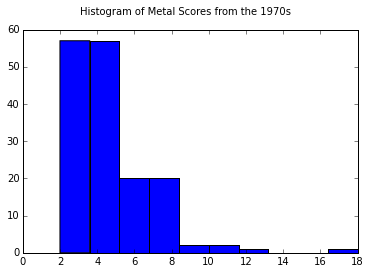

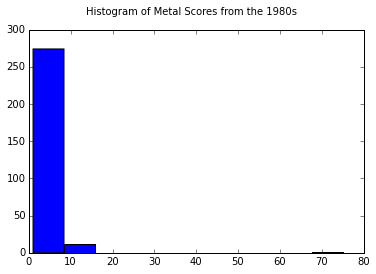

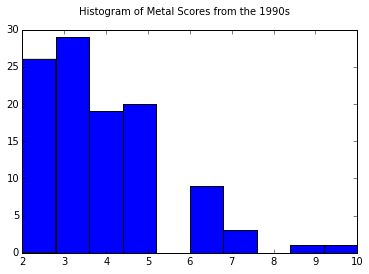

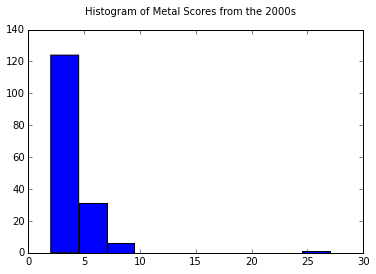

In [17]:
def metal_calculator(begin, end, plot=True):
    metal_scores = []

    query = {"year": {"$gte": begin, "$lte": end}}
    projection = {"metal_score": 1, "year": 1, "_id": 0}

    for film in hmm.find(query, projection):
        metal_scores.append(film["metal_score"])

    if plot:
        title = "Histogram of Metal Scores from the %ds" % (begin)
        fig = plt.figure()
        fig.suptitle(title)
        plt.hist(metal_scores)
        
    avg_metal_score = sum(metal_scores) / float(len(metal_scores))
    return avg_metal_score

for year in range(1970, 2010, 10):
    avg_metal_score = metal_calculator(year, year + 9)
    print "Average metal score for the %ds is %.2f" % (year, avg_metal_score)
    
## From the results we can clearly see that the most metal decade was the 1970s.